Connected to .venv (Python 3.10.7)

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-07 16:16:58.542011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 16:16:58.558767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 16:16:58.580411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 16:16:58.586974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 16:16:58.604023: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 150, 150, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])
    
    

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-07 16:17:05.937630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-07 16:17:05.938276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22461 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 25, 25,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 25,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 256) │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 256) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 512) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 512) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,049,088 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 3,074,254 (11.73 MB)

 Trainable params: 3,072,334 (11.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


I0000 00:00:1731014232.353580    4955 service.cc:146] XLA service 0x7efa3800a980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731014232.353652    4955 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1731014232.353661    4955 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-07 16:17:12.527816: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 16:17:12.999883: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-07 16:17:15.299675: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 16:17:17.838114: I externa

 12/225 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - dense_1_accuracy: 0.0783 - dense_1_loss: 3.4767 - dense_5_loss: 0.4326 - dense_5_mae: 0.8027 - loss: 3.9093

I0000 00:00:1731014246.106202    4955 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - dense_1_accuracy: 0.0880 - dense_1_loss: 2.6311 - dense_5_loss: 0.3688 - dense_5_mae: 0.7415 - loss: 2.9999

2024-11-07 16:17:36.942715: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_341', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - dense_1_accuracy: 0.0880 - dense_1_loss: 2.6296 - dense_5_loss: 0.3680 - dense_5_mae: 0.7408 - loss: 2.9976 - val_dense_1_accuracy: 0.0811 - val_dense_1_loss: 2.4954 - val_dense_5_loss: 0.2507 - val_dense_5_mae: 0.6373 - val_loss: 2.7468 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - dense_1_accuracy: 0.0904 - dense_1_loss: 2.4665 - dense_5_loss: 0.2477 - dense_5_mae: 0.6325 - loss: 2.7142 - val_dense_1_accuracy: 0.0822 - val_dense_1_loss: 2.5034 - val_dense_5_loss: 0.2527 - val_dense_5_mae: 0.6395 - val_loss: 2.7574 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_1_accuracy: 0.1327 - dense_1_loss: 2.3639 - dense_5_loss: 0.2291 - dense_5_mae: 0.5933 - loss: 2.5930 - val_dense_1_accuracy: 0.1733 - val_dense_1_loss: 2.3316 - val_dense_5_loss: 0.2364 - val_dense_5_mae: 0.6125 - val_loss: 2.5603 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - d

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

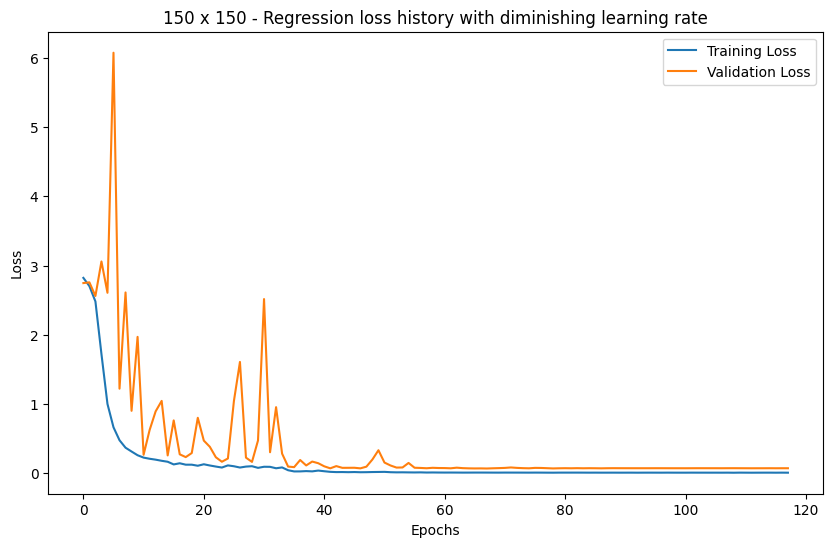

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 16:24:59.052769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

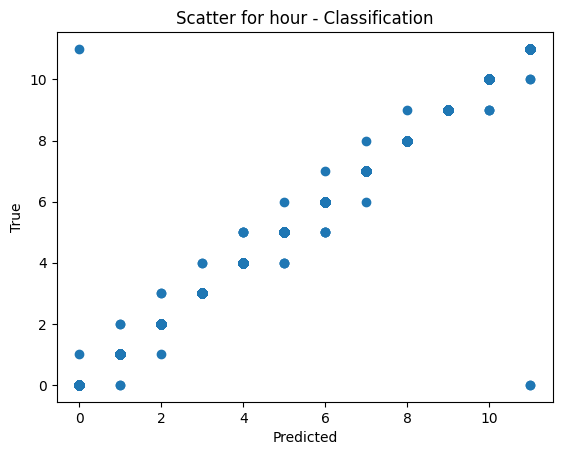

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

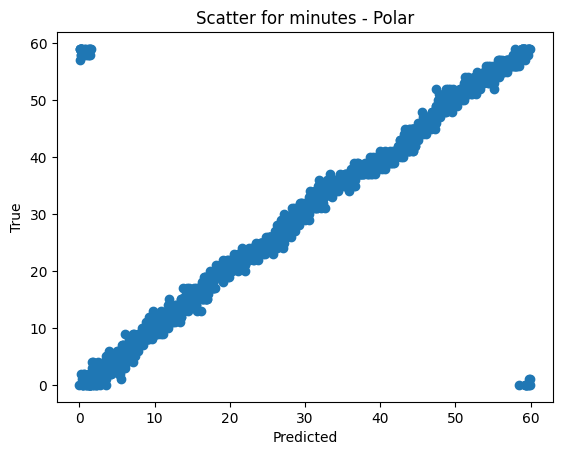

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

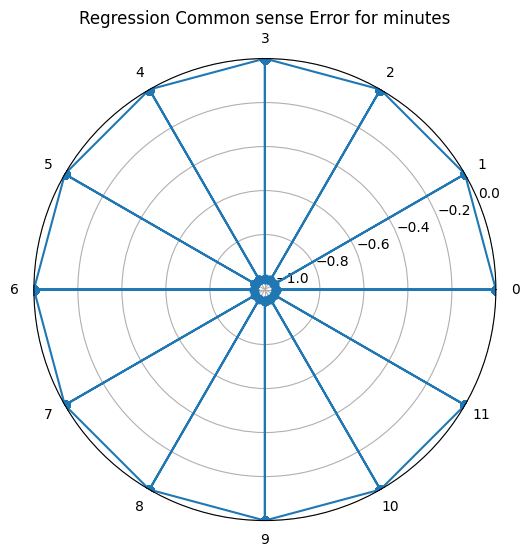

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

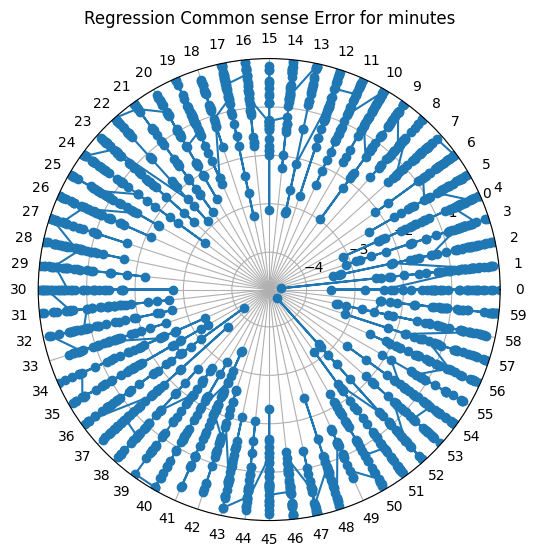

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(60))

plt.show()

In [ ]:
# y_train_pred = model.predict(x_train.reshape(x_train.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_train_pred.flatten()-y_train)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_train = np.mean(common_sense_error)

# #%%
# y_val_pred = model.predict(x_val.reshape(x_val.shape[0], img_rows, img_cols)).flatten()
# abs_values = abs(y_val_pred.flatten()-y_val)
# common_sense_error = np.minimum(abs_values, 12. - abs_values)
# cse_val = np.mean(common_sense_error)

# #%%

# min(history.history['val_loss'])

# #%%
# min_val_loss_index = history.history['val_loss'].index(min(history.history['val_loss']))
# history.history['loss'][min_val_loss_index]
# # %%
# history.history['mae'][min_val_loss_index]

# #%%
# history.history['val_mae'][min_val_loss_index]

# #%%
# print(f"Min Val loss : {min(history.history['val_loss'])}")
# print(f"Loss at this : {history.history['loss'][min_val_loss_index]}")
# print(f"MAE : {history.history['mae'][min_val_loss_index]}")
# print(f"MAE Val : {history.history['val_mae'][min_val_loss_index]}")
# print(f"Common Sense MAE Train : {cse_train}")
# print(f"Common Sense MAE Val : {cse_val}")
# print(f"Common Sense MAE Test : {score}")

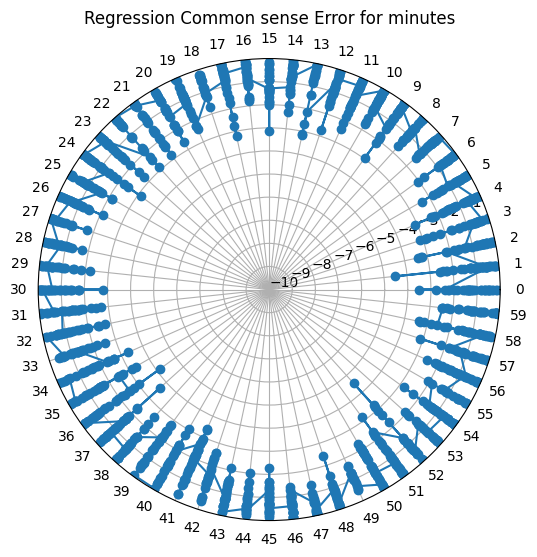

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 12,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 12, 12,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 128) │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 4, 4, 256) │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 2, 2, 256) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 2, 2, 512) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 1, 1, 512) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 512) │      2,048 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    262,656 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ dense_8[0][0]   

 Total params: 2,091,214 (7.98 MB)

 Trainable params: 2,089,294 (7.97 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-07 16:59:29.373974: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - dense_11_loss: 0.3173 - dense_11_mae: 0.6876 - dense_7_accuracy: 0.1165 - dense_7_loss: 2.7704 - loss: 3.0878 - val_dense_11_loss: 0.2875 - val_dense_11_mae: 0.6681 - val_dense_7_accuracy: 0.0750 - val_dense_7_loss: 2.7929 - val_loss: 3.0741 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_11_loss: 0.2122 - dense_11_mae: 0.5532 - dense_7_accuracy: 0.2973 - dense_7_loss: 1.8234 - loss: 2.0356 - val_dense_11_loss: 0.2518 - val_dense_11_mae: 0.6372 - val_dense_7_accuracy: 0.0972 - val_dense_7_loss: 3.7504 - val_loss: 4.0225 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_11_loss: 0.1991 - dense_11_mae: 0.5390 - dense_7_accuracy: 0.6092 - dense_7_loss: 0.9496 - loss: 1.1487 - val_dense_11_loss: 0.3444 - val_dense_11_mae: 0.6999 - val_dense_7_accuracy: 0.2989 - val_dense_7_loss: 2.1135 - val_loss: 2.4448 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

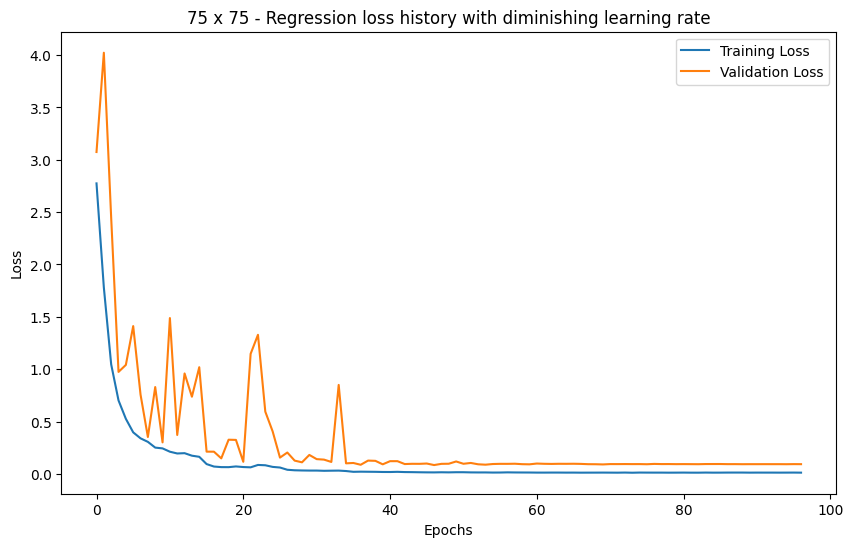

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

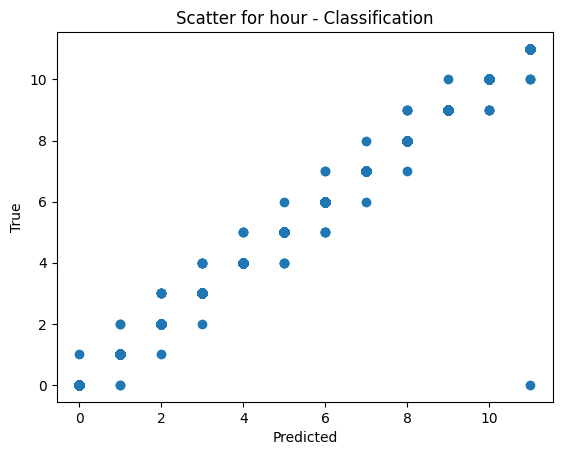

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

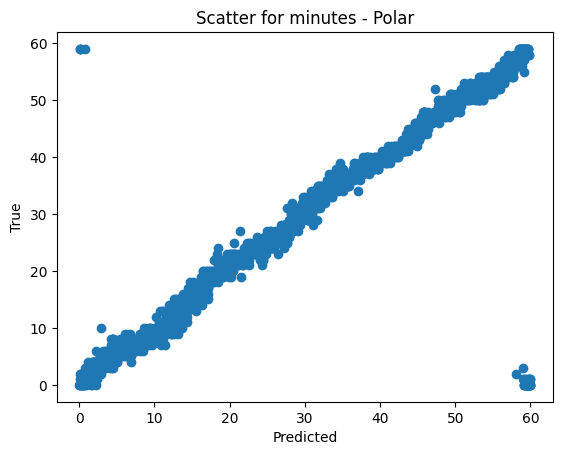

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

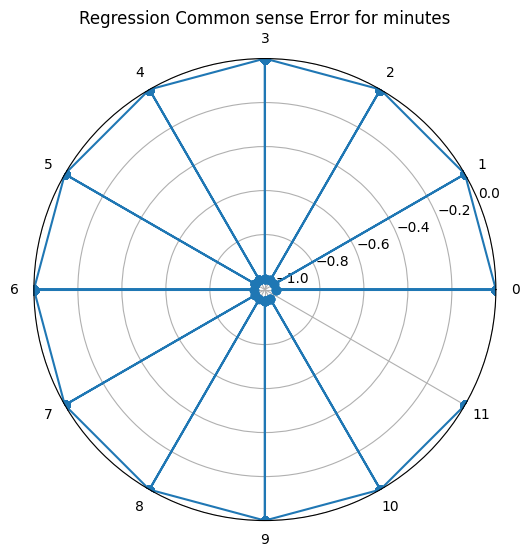

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

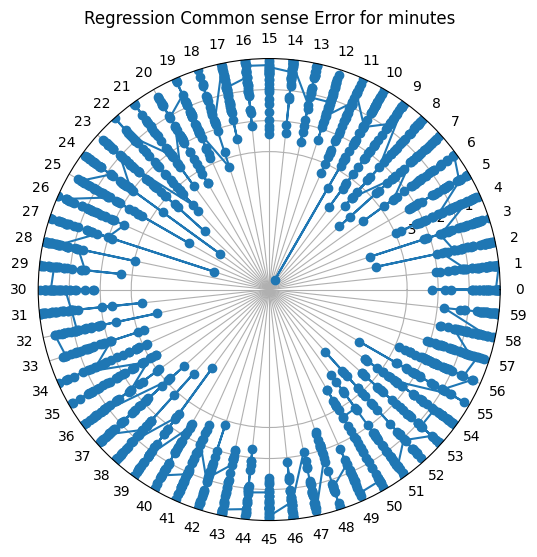

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-3, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

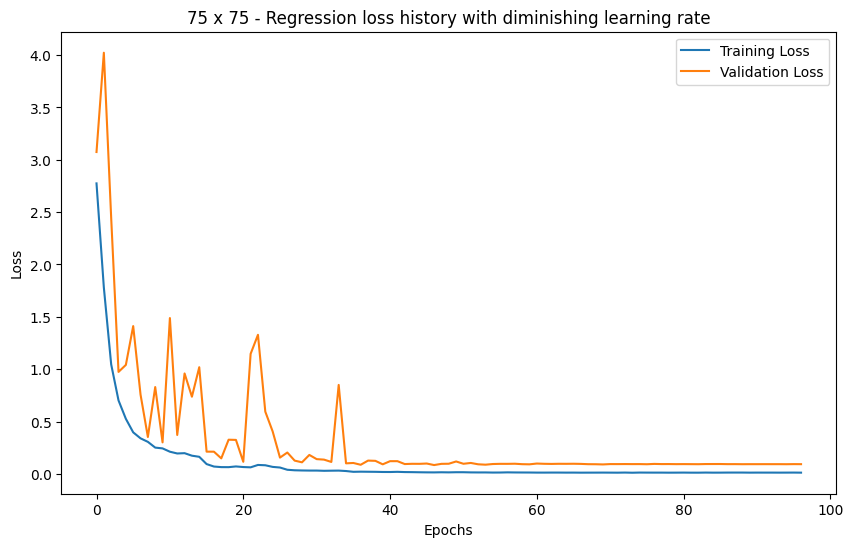

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

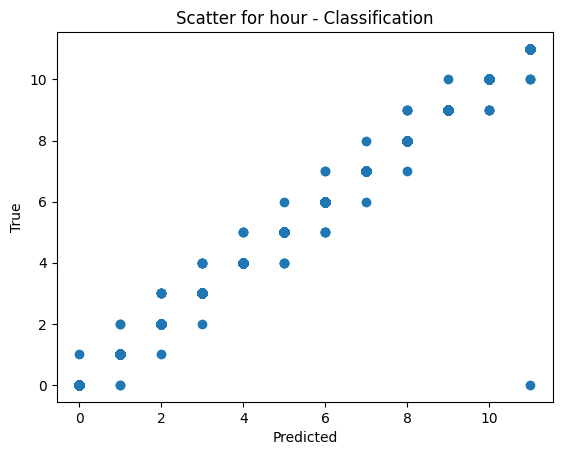

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

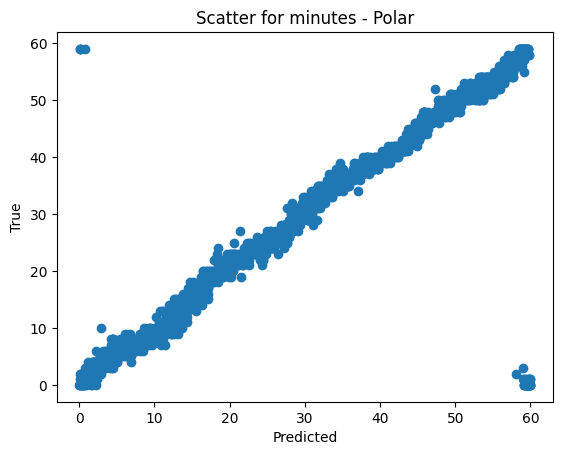

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

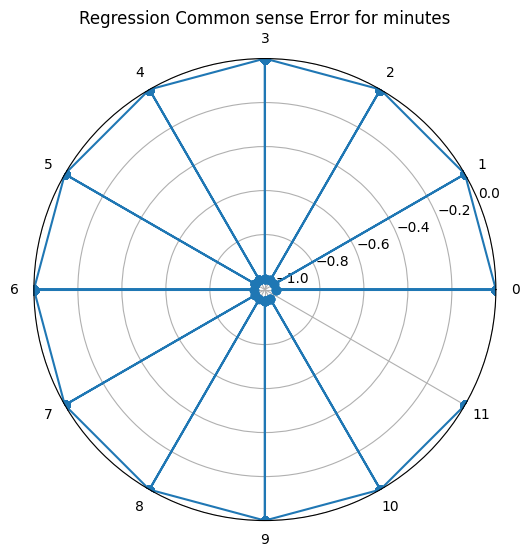

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

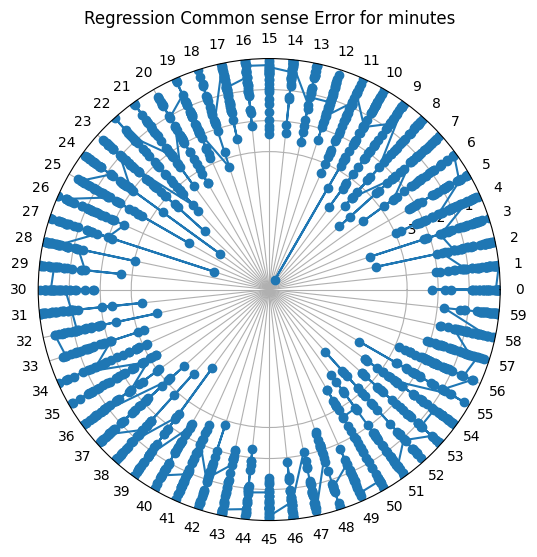

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-3, 0))
ax.set_xticklabels(range(60))

plt.show()

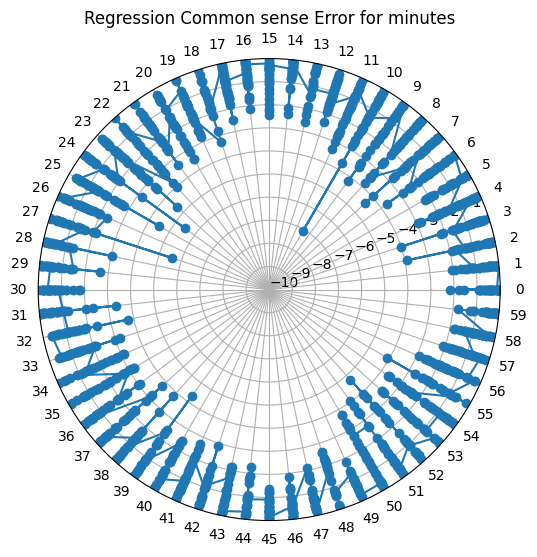

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
import math
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map (hour, minute) tuples to float values upto 
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)


y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)


# y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
# y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)


print(y_train_hours.shape)
print(y_train_minutes.shape)

(14400, 12)
(14400, 2)


In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    # x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print(x_val.shape)

(1800, 75, 75, 1)


In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

                            
    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
                            

    #final layer begins
    f = keras.layers.Flatten()(b4)
                           
                           
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)


    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)

    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
        
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)

    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)
                          
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 150, 150,  │      3,200 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 25, 25,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 25, 25,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 25, 25,    │          0 │ conv2d_13[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 128) │          0 │ dropout_21[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_13… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 8, 8, 256) │          0 │ conv2d_14[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 4, 256) │          0 │ dropout_22[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_14… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 4, 4, 512) │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 2, 2, 512) │          0 │ dropout_23[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ max_pooling2d_15… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │  1,049,088 │ flatten_3[0][0] 

 Total params: 3,074,254 (11.73 MB)

 Trainable params: 3,072,334 (11.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=50,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=5, min_lr=1e-6
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stopping]
)

Epoch 1/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - dense_19_accuracy: 0.0827 - dense_19_loss: 2.6279 - dense_23_loss: 0.3731 - dense_23_mae: 0.7430 - loss: 3.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - dense_19_accuracy: 0.0766 - dense_19_loss: 2.4851 - dense_23_loss: 0.2503 - dense_23_mae: 0.6371 - loss: 2.7354
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - dense_19_accuracy: 0.0842 - dense_19_loss: 2.4853 - dense_23_loss: 0.2501 - dense_23_mae: 0.6365 - loss: 2.7355
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - dense_19_accuracy: 0.0835 - dense_19_loss: 2.4855 - dense_23_loss: 0.2488 - dense_23_mae: 0.6338 - loss: 2.7343
Epoch 5/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - dense_19_accuracy: 0.0864 - dense_19_loss: 2.4858 - dense_23_loss: 0.2463 - dense_23_mae: 0.6285 - loss: 2.7321
Epoch 6/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - dense_19_accuracy: 0.0757 - dense_19_loss: 2.4854 - dense_23_loss: 0.2412 - dense_23_mae: 0.6194 - loss

In [ ]:
loss = history.history['loss']
# val_loss = history.history['val_loss']

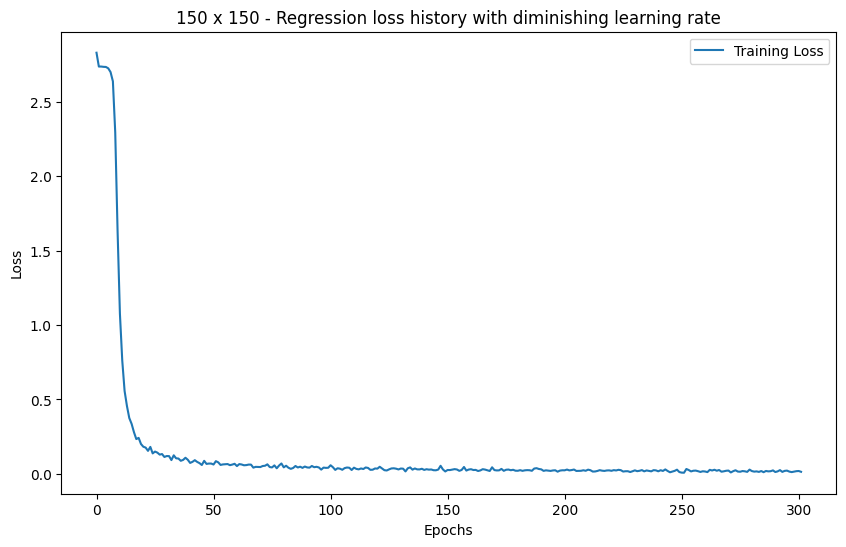

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-11-07 18:45:04.602699: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

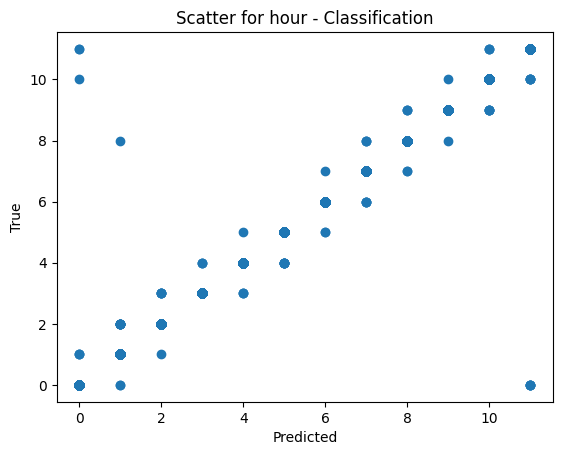

In [ ]:
plt.scatter(y_pred_hours, y_test_hours)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes =  y_test[:,1]
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)


abs_mins = abs(y_pred_mins-y_test[:,1])
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

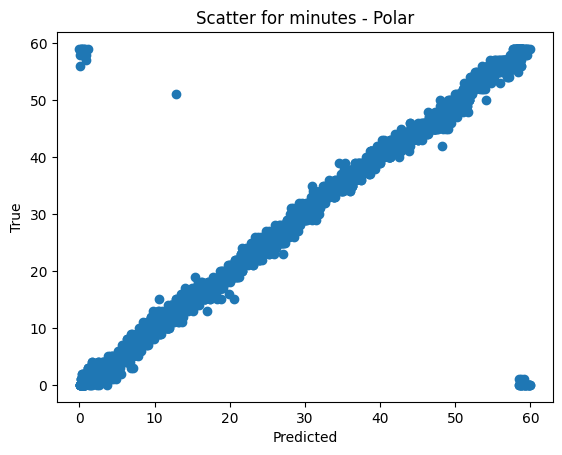

In [ ]:
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

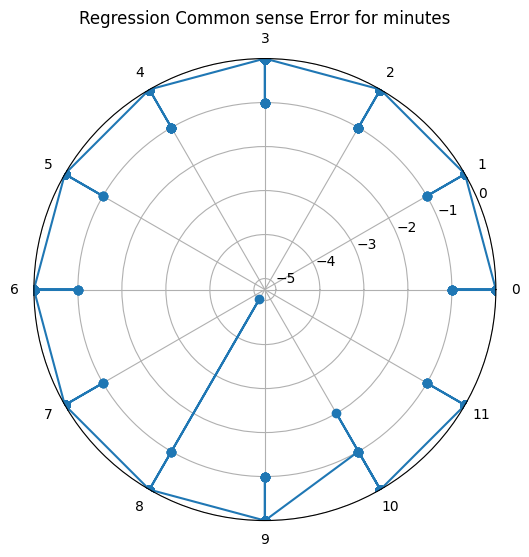

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours)
sorted_y_test_hr = y_test_hours[sorted_indices_hr]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

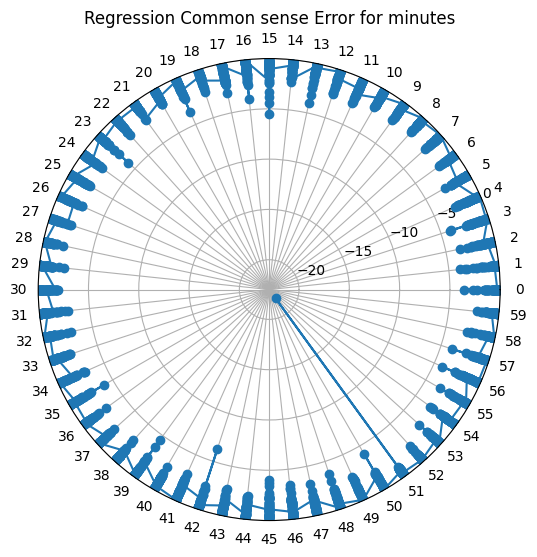

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes)
sorted_y_test_min = y_test_minutes[sorted_indices_min]

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Regression Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")


print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_19_accuracy: 0.9977083206176758
Train dense_19_loss: 0.008827687241137028
Train dense_23_loss: 0.005760061088949442
Train dense_23_mae: 0.07741792500019073
Train loss: 0.014587748795747757

Test dense_19_accuracy: 0.9797222018241882
Test dense_19_loss: 0.09840133786201477
Test dense_23_loss: 0.09464586526155472
Test dense_23_mae: 0.003334115259349346
Test loss: 0.057738665491342545

Common Sense MAE Min Test: 0.01391830122425691
